# model_eicu_optimize


## Prepare


In [1]:
import shap
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_validate, StratifiedGroupKFold
from common_eicu import KEY_IDENTITY, KEY_FLAG, CATEGORICAL_COLUMNS
from common_model_eicu import SEED, SCORING, get_full_data, test_model


In [2]:
plt.rcParams['figure.facecolor'] = '#FFF'

shap.initjs()


In [3]:
df_data = get_full_data() \
    .sort_values(by=KEY_IDENTITY)


In [4]:
X = df_data.drop(columns=[KEY_IDENTITY, KEY_FLAG])
y = df_data[KEY_FLAG].ravel()
groups = df_data[KEY_IDENTITY].ravel()
pool = Pool(
    X,
    y,
    cat_features=CATEGORICAL_COLUMNS,
    group_id=groups,
)


## Overfitting Detection


In [4]:
# split data

train_test_splitter = StratifiedGroupKFold(
    n_splits=10,
    shuffle=True,
    random_state=SEED,
)
train_indices, test_indices = next(
    train_test_splitter.split(X, y, groups)
)

X_train = X.iloc[train_indices, :]
y_train = y[train_indices]
groups_train = groups[train_indices]
pool_train = Pool(
    X_train,
    y_train,
    cat_features=CATEGORICAL_COLUMNS,
    group_id=groups_train,
)

X_test = X.iloc[test_indices, :]
y_test = y[test_indices]
groups_test = groups[test_indices]
pool_test = Pool(
    X_test,
    y_test,
    cat_features=CATEGORICAL_COLUMNS,
    group_id=groups_test,
)


In [5]:
catboost_model_od = CatBoostClassifier(
    task_type='GPU',
    devices='0',
    iterations=888,
    od_pval=1e-2,
    random_state=SEED,
    verbose=False,
)


In [6]:
catboost_model_od.fit(
    pool_train,
    eval_set=pool_test,
)


In [7]:
catboost_model_od.best_iteration_


427

## Parameter Search


In [7]:
%%time

# stats.randint(low, high) -> [low, hight)
# stats.uniform(loc, scale) -> [loc, loc + scale]
param_distributions = {
    'iterations': stats.randint(100, 1000),
    'learning_rate': stats.uniform(0.01, 0.20),
    'depth': [6, 7, 8, 9, 10],
    'bagging_temperature': stats.uniform(1, 100),
    'l2_leaf_reg': stats.uniform(1, 200),
}

search_cv = StratifiedGroupKFold(
    n_splits=3,
    shuffle=True,
    random_state=SEED,
)

catboost_model_search = CatBoostClassifier(
    task_type='GPU',
    devices='0',
    random_state=SEED,
    verbose=False,
)

# TODO: change eval metric
search_result = catboost_model_search.randomized_search(
    param_distributions,
    pool,
    # `cv.split` must be invoked to provide group info
    cv=search_cv.split(X, y, groups),
    n_iter=8,
    refit=False,
    calc_cv_statistics=False,
    shuffle=False,
    plot=True,
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.03352978029
bestIteration = 851
0:	loss: 0.0335298	best: 0.0335298 (0)	total: 54.8s	remaining: 6m 23s
bestTest = 0.2010568915
bestIteration = 12
1:	loss: 0.2010569	best: 0.0335298 (0)	total: 1m 11s	remaining: 3m 35s
bestTest = 0.02994473655
bestIteration = 368
2:	loss: 0.0299447	best: 0.0299447 (2)	total: 1m 36s	remaining: 2m 40s
bestTest = 0.201837423
bestIteration = 23
3:	loss: 0.2018374	best: 0.0299447 (2)	total: 1m 46s	remaining: 1m 46s
bestTest = 0.2010582187
bestIteration = 9
4:	loss: 0.2010582	best: 0.0299447 (2)	total: 2m 17s	remaining: 1m 22s
bestTest = 0.2027188742
bestIteration = 11
5:	loss: 0.2027189	best: 0.0299447 (2)	total: 2m 31s	remaining: 50.4s
bestTest = 0.02641988474
bestIteration = 73
6:	loss: 0.0264199	best: 0.0264199 (6)	total: 5m 19s	remaining: 45.6s
bestTest = 0.0251926854
bestIteration = 443
7:	loss: 0.0251927	best: 0.0251927 (7)	total: 7m 5s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
bestTest = 0.01717318257
bestIteration =

In [12]:
print('Best Parameters:')
for key, value in search_result['params'].items():
    if int(value) == value:
        print(f'{key} = {int(value):d}')
    else:
        print(f'{key} = {value:.4f}')


Best Parameters:
depth = 9
bagging_temperature = 4.5209
learning_rate = 0.0664
l2_leaf_reg = 73.0576
iterations = 445


## Optimized Full Model


In [13]:
catboost_model_optimized = CatBoostClassifier(
    cat_features=CATEGORICAL_COLUMNS,
    task_type='GPU',
    devices='0',
    iterations=450,
    depth=9,
    bagging_temperature=13.9286,
    learning_rate=0.0344,
    l2_leaf_reg=3.1075,
    random_state=SEED,
    verbose=False,
)


In [14]:
%%time
test_model(catboost_model_optimized, X, y, groups)


>>> CV Result
accuracy_mean: 0.9954
accuracy_std:  0.0012
auc_mean:      0.9950
auc_std:       0.0016
CPU times: total: 5min 26s
Wall time: 4min 18s


## SHAP


In [15]:
catboost_model_optimized.fit(pool)


In [17]:
explainer = shap.Explainer(catboost_model_optimized)
shap_values = explainer(X)


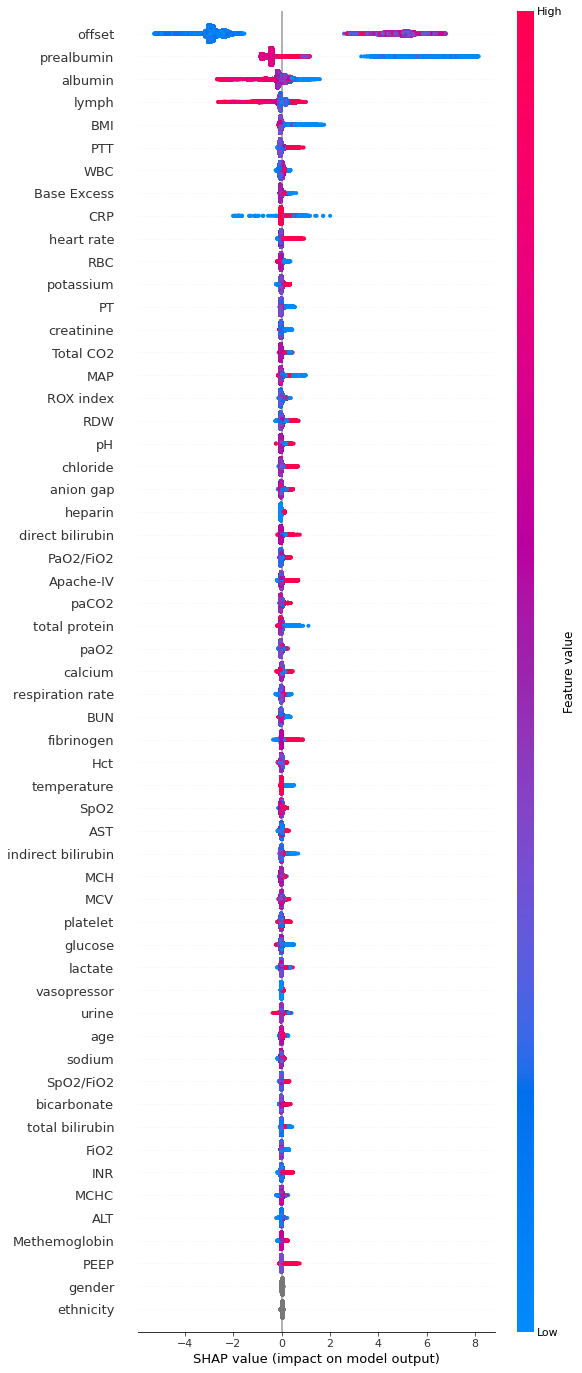

In [18]:
shap.plots.beeswarm(
    shap_values,
    max_display=99,
)


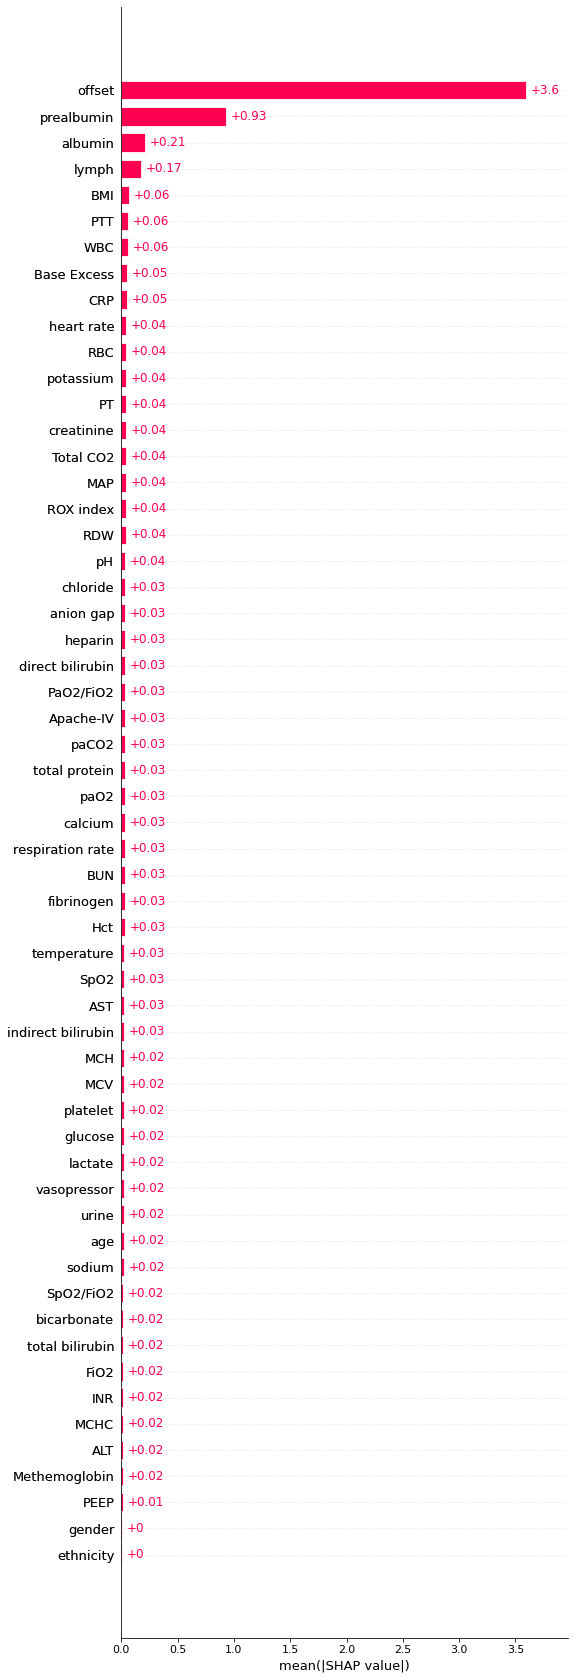

In [19]:
shap.plots.bar(
    shap_values,
    max_display=99,
)
